# Reduce maintenance cost through predictive techniques

Author: Daniel Noce da Silva

In this notebook, it is developed a device failure predictive model.

###  Goals

- To build a predictive model in order to estimate **probability of device failure**, given the daily aggregated telemetry data.
- Minimize **false positives** and **false negatives** in dev set (test set) predictions

### Notebook summary:

#### Data exploration and modelling insights:

    - Importing data
    - General statistics
    - Visualizing failures over time
    - Sequence length analisys
    - Addressing gaps in sequence data
    - Attributes' distributions
    

#### Predictive Modelling

    - Data prep
    - Modelling helper functions
    - Random generation of hyperparameter sets and model selection
    - Selecting the model with highest F1-Score at dev set
    - Performance at the validation set

#### Appendix 1 : Cost reduction

## Data Exploration and Modelling Insights

### Importing data

In [1]:
# dataset manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# modelling and diagnostics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, precision_score, recall_score,\
precision_recall_fscore_support, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# In order to improve pdf readability
import pprint

pp = pprint.PrettyPrinter(indent=0)
pprint = pp.pprint

In order to apply calculations to the **'date'** column, we create a datetime variable **'datenum'**.

In [3]:
# using latin1  - data do not conform to utf-8
df = pd.read_csv('device_failure.csv', encoding='latin1')

# converting dates to a more suitable format
df['datenum'] = pd.to_datetime(df.date, format='%Y-%m-%d')
df.drop('date', inplace = True, axis=1)

In [4]:
# data sample
df.head()

,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,datenum
0,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,2015-01-01
1,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,2015-01-01
2,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,2015-01-01
3,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,2015-01-01
4,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,2015-01-01


In [5]:
# There is one device-date pair with duplicated data
t1 = df.groupby(['device','datenum']).failure.count()
t1[t1>1]

df.query("device == 'S1F0R4Q8' and datenum == '2015-07-10'")

,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,datenum
101334,S1F0R4Q8,0,192721392,0,0,0,8,213700,0,0,0,2015-07-10
101335,S1F0R4Q8,0,192721392,0,0,0,8,213700,0,0,0,2015-07-10


In [6]:
#remove duplicate
df.drop_duplicates(subset=None, keep='first', inplace=True)

In [7]:
# checking column dtypes and info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124493 entries, 0 to 124493
Data columns (total 12 columns):
device        124493 non-null object
failure       124493 non-null int64
attribute1    124493 non-null int64
attribute2    124493 non-null int64
attribute3    124493 non-null int64
attribute4    124493 non-null int64
attribute5    124493 non-null int64
attribute6    124493 non-null int64
attribute7    124493 non-null int64
attribute8    124493 non-null int64
attribute9    124493 non-null int64
datenum       124493 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 12.3+ MB
None


In [8]:
# no missing data was found
df.isnull().sum()

device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
datenum       0
dtype: int64

### General statistics

The following code helps us to get an overview of the dataset content:
    
- The **number of devices** is **1169**
- The **maximum failures per device** observed in the dataset is: **1**
- The number of **devices with history of failure** is **106**
- The **percentage** of equipaments with history of failure is **9.1**

In [9]:
# general statistics
num_dev = np.unique(df.device).shape[0]
print('The number of devices is %d'%num_dev)

# There is no observation of two failures for the same device
df_failure = df[df.failure==1].copy()
failures_per_device = df_failure.groupby('device').failure.sum().max()
print(
    'The maximum failures per device observed in the dataset is: %d'
    %failures_per_device)

num_f = df_failure.groupby('device').failure.count().count()
print('The number of equipaments with history of failure is %d'%(num_f,))

pct_f = df.failure.sum()/len(np.unique(df.device.values))
print('The percentage of equipaments with history of failure is %.1f'%(pct_f*100,))

The number of devices is 1169
The maximum failures per device observed in the dataset is: 1
The number of equipaments with history of failure is 106
The percentage of equipaments with history of failure is 9.1


### Visualizing failures over time

Over time, the frequency of failures per device in the dataset is slowing down. Also, it is possible to see that multiple failures in one day or in a sequence of days are not uncommon.

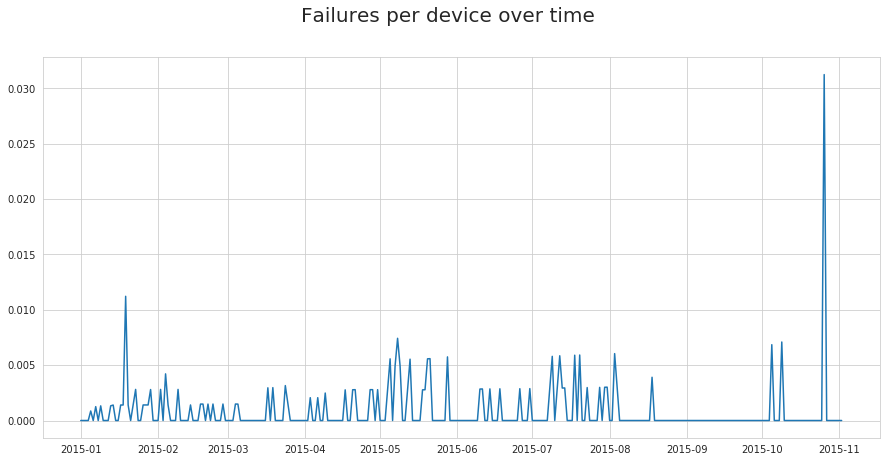

In [11]:
fig = plt.figure(figsize=(15,7))

# percentage of failures per device through time
failure_pct = df.groupby('datenum').failure.sum()/df.groupby('datenum').failure.count()
sns.lineplot(data=failure_pct)
fig.suptitle('Failures per device over time', fontsize=20)
plt.show()

The distribution of failure quantity (below) shows that 20% of days with failure have two or more devices failing.

Hence, there is a possibility that a net effect of past days failures of other equipment may influence the probability of failure for a device. Later we will add a new feature that is the absolute number of failures up to d-1. This feature can handle possible interactions between devices (to be tested on model).

In [12]:
failure_count = df.groupby('datenum').failure.sum()
# selecting only days with device failures
failure_count = failure_count[failure_count>0]
failure_count.describe(percentiles=[.8, .9, .95])

count    76.000000
mean      1.394737
std       0.924899
min       1.000000
50%       1.000000
80%       2.000000
90%       2.000000
95%       2.000000
max       8.000000
Name: failure, dtype: float64

### Sequence length analysis

This is a dataset of sequence data, which suggests that the proper modelling tools for this case are RNN's. To do so, we need to know more about the sequence length for each device. If we disregard sequences that have gaps, for now, we have an approx. distribution of lengths in the following figure: 

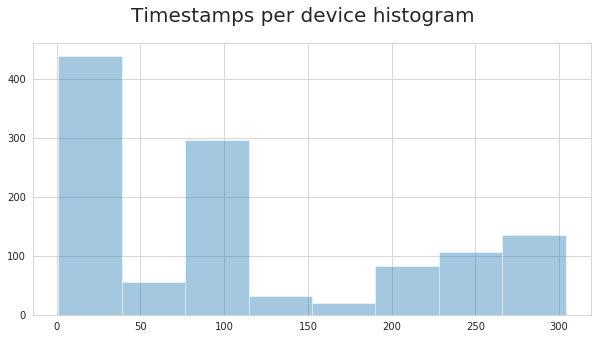

In [14]:
# absolute number of timestamps per device
timestamps_per_device = df.groupby('device').datenum.count()
fig = plt.figure(figsize=(10,5))
ax = sns.distplot(timestamps_per_device.values, kde=False)
fig.suptitle('Timestamps per device histogram', fontsize=20)
plt.show()

The median of timestamps is 84. And there is a significative number of devices with 6 or less timestamps.

In [15]:
timestamps_per_device.describe()

count    1169.000000
mean      106.495295
std       102.651359
min         1.000000
25%         6.000000
50%        84.000000
75%       224.000000
max       304.000000
Name: datenum, dtype: float64

Here , one example of device data that appears for six days in January

In [16]:
df[df.device == 'S1F02VAX']

,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,datenum
14,S1F02VAX,0,61019512,168,2,521,3,380496,0,0,3,2015-01-01
1177,S1F02VAX,0,111341488,168,2,521,3,380496,0,0,3,2015-01-02
2340,S1F02VAX,0,167108304,168,2,521,3,380496,0,0,3,2015-01-03
3503,S1F02VAX,0,122926824,168,2,521,3,380660,0,0,3,2015-01-04
4665,S1F02VAX,0,142917800,168,2,521,3,381832,0,0,3,2015-01-05
5826,S1F02VAX,0,172600768,168,2,521,3,382898,0,0,3,2015-01-06


### Addressing gaps in sequence data

In the following, we verify that there is significative time gaps in sequence data for several devices. Then, we separate sequences for each device, in order to model these sequences as independent examples.

The number of devices is originally 1169. After sequence separation for devices with gaps in time sequece, we increase the number of examples to 1389.

In [17]:
# This code verfy how many devices have gaps in sequence data

# for every device, verify if there are gaps in sequence data
df.sort_values(by=['device','datenum'], inplace=True)

devices_with_gaps = list()
gap_per_device = list()
for device in np.unique(df.device.values):
    
    #select determined device data
    df_device = df[df.device == device].copy()
    
    #calculate days between timestamps
    timestamp_diff = df_device.datenum.diff()
    diff = timestamp_diff.dt.days # days in integer
    
    # if diff > 1 there is a gap
    max_ = diff.max()
    if max_ > 1:
        devices_with_gaps.append(device)
        gap_per_device.append(max_)
        

print('''The number of devices with gaps in sequence data:
%d with mean value of approx. %.0f days in a gap'''
      %(len(devices_with_gaps), np.mean(gap_per_device)))

The number of devices with gaps in sequence data:
173 with mean value of approx. 40 days in a gap


All data with gaps should be divided in separate sequences. The following code separates each device data into a small dataframe and then calculates differences in days between ordered timestamps.

In [18]:
df_list = []
for device in np.unique(df.device):
   
    #select determined device data
    df_device = df[df.device == device].copy()
    
    #calculate days between timestamps
    timestamp_diff = df_device.datenum.diff()
    df_device['diff'] = timestamp_diff.dt.days # days in integer
    
    # keep it 
    df_list.append(df_device)
    
df = pd.concat(df_list, axis = 0)
df['diff'].fillna(0, inplace = True)
num_devices = len(np.unique(df.device))

In [19]:
#check the new column diff
df.head()

,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,datenum,diff
0,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,2015-01-01,0.0
1163,S1F01085,0,1650864,56,0,52,6,407438,0,0,7,2015-01-02,1.0
2326,S1F01085,0,124017368,56,0,52,6,407438,0,0,7,2015-01-03,1.0
3489,S1F01085,0,128073224,56,0,52,6,407439,0,0,7,2015-01-04,1.0
4651,S1F01085,0,97393448,56,0,52,6,408114,0,0,7,2015-01-05,1.0


Then iterates over all data, writing a new suffix in the device id in order to separate sequences.

In [20]:
# counts the number of gaps found
global_cumsum = 0
# current device name
curr_device = ''

#iterates over all devices separating sequences changing device id
for row in df.iterrows():
    
    # first row per device
    if row[1]['diff'] == 0:
        curr_device = row[1]['device']
        cumsum_device = 0
        
    # if updates device id
    if curr_device != row[1]['device']:
        df.loc[row[0], 'device'] = curr_device
        
    # identify gaps and adds sufix to device id
    if row[1]['diff']>1:
        cumsum_device +=1
        global_cumsum +=1
        new_device = row[1]['device']+"_"+str(cumsum_device)
        df.loc[row[0], 'device']  = new_device
        curr_device = new_device

In [21]:
new_num_devices = len(np.unique(df.device)) 
print('The new number of examples (device sequences) is %d'%new_num_devices)

# checking the increase at the number of devices
assert(global_cumsum == new_num_devices - num_devices)

The new number of examples (device sequences) is 1389


### Attributes' distributions

The attributes' distributions indicate different ranges per attribute and also a significative presence of outliers. The presence of outliers suggests the use of min_max scaler, because with standard scaling we would end up with different data ranges per attribute.

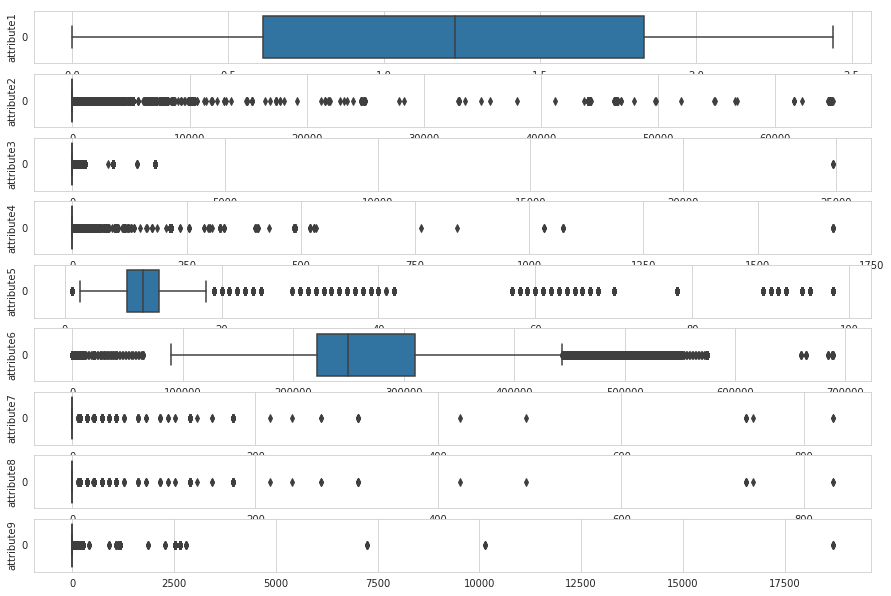

In [22]:
var_list = list()
for i in range(1,10):
    var_list.append('attribute'+str(i))

# let's see distributions
n_plots = len(df.columns)

fig, ax = plt.subplots(figsize=(15, 15))
for column in enumerate(var_list):
    plt.subplot(n_plots,1,1+column[0])
    plt.ylabel(column[1])
    sns.boxplot(data=df[column[1]],orient="h")
plt.show()

## Predictive Modelling

The use of RNN's is appropriate for sequence data in our dataset.

After some tests with simpler models, the ***one layer LSTM with Adam optimizer and Dropout was chosen***. 

Given that configuration, randomly generated hyperparameter sets were evaluated to chose the one that giver better performance.

***With the purpose of preventing false negatives and false positives, the metric chosen for hyperparameter search was F1-Score (dev set), which balances precision and recall.***

In [25]:
# sorting data
df.sort_values(by=['device','datenum'], inplace=True)

# list of attributes that are going to be inputs for the model
var_list = list()
for i in range(1,11):
    var_list.append('attribute'+str(i))

We add a new feature that is the absolute number of failures up to d-1. This feature  can handle possible interactions between devices (to be tested on model).

In [26]:
# new feature
failures = df.groupby('datenum').failure.sum()
failures=failures.shift(periods=1, freq=None, axis=0)
failures=failures.to_frame()
failures.reset_index(inplace=True)
failures.fillna(0, inplace=True)
failures.rename({'failure': 'attribute10'}, axis = 1, inplace=True)
df=df.merge(failures, on = 'datenum', how = 'left')

### Data prep

- Sequence padding
- Train/Dev/Validation sets
- Scaling

The sequences of timestamps per device have a 84 days median. In the following, we pad sequences to 10 days. After testing different intervals, this was the one that resulted in better performance.

**Note: I am using 'dev set' and 'test set' terminology interchangeably**

In [27]:
# model parameters
EPOCHS = 600 # global var
num_devices = np.unique(df.device).shape[0]
data_dim = len(var_list)
timesteps=10
num_classes = 2

In [28]:
# transforming data in np.arrays
X = list()
Y = list()
for device in enumerate(np.unique(df.device)):
    X.append(df[df.device==device[1]][var_list].values)
    Y.append(df[df.device==device[1]]['failure'].values)

In [29]:
# Padding sequences

# sequences: List of lists, where each element is a sequence.
# returns x: Numpy array with shape (len(sequences), maxlen)

X_pad = pad_sequences(
    X, maxlen=timesteps, dtype='int32', 
    padding='pre', truncating='pre', value=0.0)

Y_pad = pad_sequences(
    Y, maxlen=timesteps, dtype='int32',
    padding='pre', truncating='pre', value=0.0)

print("X_pad and Y_pad shapes:")
print()
print(X_pad.shape)
print(Y_pad.shape)

X_pad and Y_pad shapes:

(1389, 10, 10)
(1389, 10)


In [30]:
# Most of failure data is located at the end of the sequence or inside padding range
print("The majority of failures it is already located at the end of the sequences:")
print()
for i in range(timesteps):
    print('t%d: %d'%(i,Y_pad[:,i].sum()))
print()
print("Of %d failures in data, the padding has mantained %d"
      %(df.failure.sum(),Y_pad.sum()))

The majority of failures it is already located at the end of the sequences:

t0: 0
t1: 0
t2: 0
t3: 0
t4: 0
t5: 0
t6: 0
t7: 2
t8: 1
t9: 101

Of 106 failures in data, the padding has mantained 104


In [31]:
# Shuffling data
np.random.seed(1)
arr = np.arange(X_pad.shape[0]-1)
np.random.shuffle(arr)

# Train, Test, Validation datasets
n_train = round(arr.shape[0]*0.6)
n_test = round(arr.shape[0]*0.8)
X_train, X_test, X_val = X_pad[arr[:n_train]],\
X_pad[arr[n_train:n_test]], X_pad[arr[n_test:]]

Y_train, Y_test, Y_val = Y_pad[arr[:n_train]],\
Y_pad[arr[n_train:n_test]], Y_pad[arr[n_test:]]

In [32]:
print('Train X and Y shapes:')
print('')
print(X_train.shape)
print(Y_train.shape)
print('')

print('Test X and Y shapes:')
print('')
print(X_test.shape)
print(Y_test.shape)
print('')


print('Validation X and Y shapes:')
print('')
print(X_val.shape)
print(Y_val.shape)
print('')

Train X and Y shapes:

(833, 10, 10)
(833, 10)

Test X and Y shapes:

(277, 10, 10)
(277, 10)

Validation X and Y shapes:

(278, 10, 10)
(278, 10)



In [33]:
# Reshaping Y
Y_train, Y_test, Y_val = np.reshape(Y_train,(Y_train.shape)+(1,)),\
np.reshape(Y_test,(Y_test.shape)+(1,)),np.reshape(Y_val,(Y_val.shape)+(1,))

We use minmax scaler in order to scale attributes.  Given the significative presence of outliers and sparsety we would have poor scaling using standart scaler or robust scaler.

In [34]:
def min_max_scaler(X_train, X_test, X_val):
    'Scales data according to min and max'

    min_ = X_train.min(axis = (0,1))
    max_ = X_train.max(axis = (0,1))
    max_min = max_ - min_

    X_train = (X_train - min_)/max_min
    X_test = (X_test - min_)/max_min
    X_val = (X_val - min_)/max_min
    
    return X_train, X_test, X_val


X_train, X_test, X_val = min_max_scaler(X_train, X_test, X_val)

### Modelling helper functions

In [35]:
def model_rnn_fit(hyperparameters, X_train, Y_train):
    
    'Returns RNN model fitted with determined hyperparameters'
        
    learning_rate = hyperparameters['learning_rate']
    mini_batch_size = hyperparameters['mini_batch_size']
    units_layer1 = hyperparameters['units_layer1']
    units_layer2 = hyperparameters['units_layer2']
    lambda_reg = hyperparameters['regularizers']
    dropout_layer1 = hyperparameters['dropout_layer1']
    dropout_layer2 = hyperparameters['dropout_layer2']
    
    optimizer = Adam(
        lr=learning_rate, beta_1=0.9, beta_2=0.999,
        epsilon=None, decay=0.0, amsgrad=False)
    
    model = Sequential()
    
    model.add(LSTM(
        units=units_layer1, activation='tanh',use_bias=True,
        unit_forget_bias=True,input_shape=(timesteps, data_dim),
        return_sequences=True, kernel_regularizer=regularizers.l2(lambda_reg)))
    
    model.add(Dropout(dropout_layer1))
    
    
    model.add(
        Dense(1, activation='sigmoid', 
              kernel_regularizer=regularizers.l2(lambda_reg)))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  #sample_weight_mode="temporal",
                  metrics=['accuracy'])
    
    model.fit(X_train, Y_train, batch_size=mini_batch_size,\
              epochs=EPOCHS, verbose=False)#, sample_weight = sample_weights)
    
    return model

In [36]:
def model_eval(model, hyperparameters, X_train, Y_train, X_test, Y_test):
    
    '''Evaluates model performance on the dev set'''
    
    mini_batch_size = hyperparameters['mini_batch_size']
    
    # Metrics for the training set
    Y_train_line = np.reshape(Y_train, (-1))
    Y_pred_train_line =  np.reshape(model.predict_classes(X_train), (-1))
    train_loss = model.evaluate(
        X_train, Y_train, batch_size=mini_batch_size, verbose=False)[0]
    f1_score_train = f1_score(
        Y_train_line,Y_pred_train_line)
    
    # Metrics for the dev set
    Y_test_line = np.reshape(Y_test, (-1))
    Y_pred_line =  np.reshape(model.predict_classes(X_test), (-1))
    test_loss = model.evaluate(
        X_test, Y_test, batch_size=mini_batch_size, verbose=False)[0]
    f1_score_test = f1_score(Y_test_line,Y_pred_line)
        
    return train_loss, test_loss, f1_score_train, f1_score_test

### Random generation of hyperparameter sets and model selection

In [37]:
def powers_of_two(lower_power = 7, upper_power = 8):
    
    '''Generates RNN layer units based on powers of 2'''
    
    units = np.arange(lower_power,upper_power)
    units = np.exp2(units).astype(np.int32)  
    return units

def continuous_random_parameter(dim = 10):
    
    '''Generates random hyperparameters ranging 
    in different scales from 10^-3 to 10^-6'''
        
    alpha1 = 10*np.ones(dim)
    sigma1 = np.zeros((dim))
    
    for i in np.arange(dim):
        sigma1[i] = -3 - 3*np.random.rand()
    
    alpha1 = np.power(alpha1,sigma1).reshape(-1)

    return alpha1

def random_hyperparameters():
    
    '''Generates random hyperparameter sets 
    for each number of layer units in powers_of_two'''
    
    hpar_list = list()
    
    # units_layer
    for n_units in powers_of_two(lower_power=7, upper_power=9):
        for alpha, reg in zip(continuous_random_parameter(10), 
                              continuous_random_parameter(10)):
                hpar_list.append({#'learning_rate': alpha,
                                  #already optimized learning rate
                                  'learning_rate': 0.0006284410793378367,
                                  'mini_batch_size': 128,
                                  'units_layer1': 256,
                                  'units_layer2': 256,
                                  'regularizers': reg,
                                   # decreasing baseed on previous experience
                                  'dropout_layer1': 0.4,
                                  'dropout_layer2': 0.4})
    
    return hpar_list
    
random_hyperparameters_list = random_hyperparameters()
print("%d hyperparameter sets randomly generated"
      %len(random_hyperparameters_list))

20 hyperparameter sets randomly generated


As can be seen in the following plot, the random generation of regularizer constant and learning rate are well distributed in the log10 scale as we intended. This means that we are going to try parameters that range from 10^-1 to 10^-6 and are very well distributed along the different powers of 10.

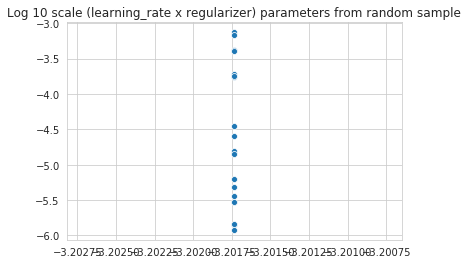

In [38]:
x = [x['learning_rate'] for x in random_hyperparameters_list]
y = [x['regularizers'] for x in random_hyperparameters_list]

sns.scatterplot(x=np.log10(x), y=np.log10(y))
plt.title('Log 10 scale (learning_rate x regularizer) parameters from random sample')
plt.show()

#This image is from a previous run

In [39]:
def hyperparameter_selection(random_hyperparameters_list,
                             X_train, Y_train, X_test, Y_test):
    
    '''Runs model fitting for a set of hyperparameters and
    returns performance'''
    
    f1_score_list = list()
    model_list = list()
    eval_list = list()

    for hyperparameters in random_hyperparameters_list:
        model = model_rnn_fit(hyperparameters, X_train, Y_train)
        eval_ = {}
        eval_['train_loss'], eval_['test_loss'],\
        eval_['f1_score_train'], eval_['f1_score_test'] = model_eval(
            model, 
            hyperparameters, 
            X_train, 
            Y_train, 
            X_test, 
            Y_test)

        #print(hyperparameters)
        f1_score_list.append(eval_['f1_score_test'])
        model_list.append(model)
        eval_list.append(eval_)
        #pprint(eval_)
        
    return f1_score_list, model_list, eval_list

In [37]:
f1_score_list, model_list, eval_list = hyperparameter_selection(
    random_hyperparameters_list, X_train, Y_train, X_test, Y_test)

### Selecting the model with highest F1-Score at dev set

In [38]:
# returns best model according to F1-measure at the dev set
f1_score_max  = 0
ind_max = 0
for i,f1_score_test in enumerate(f1_score_list):
    if f1_score_max < f1_score_test:
        f1_score_max = f1_score_test
        ind_max = i

print('''The set of hyperparameters that resulted the \
larger f1_score on the dev set: ''')
print('')
pprint(random_hyperparameters_list[ind_max])
print('')
print('')


print('Evaluation metrics for this set:')
print('')
pprint(eval_list[ind_max])

The set of hyperparameters that resulted the larger f1_score on the dev set: 

{'dropout_layer1': 0.4,
'dropout_layer2': 0.4,
'learning_rate': 0.0006284410793378367,
'mini_batch_size': 128,
'regularizers': 2.4886443045300546e-05,
'units_layer1': 256,
'units_layer2': 256}


Evaluation metrics for this set:

{'f1_score_test': 0.4444444444444444,
'f1_score_train': 0.7387387387387387,
'test_loss': 0.03476696864900176,
'train_loss': 0.01350163659897028}


### Performance at the validation set

In [45]:
# Adicional: guardando dados de validação

import pickle

with open('X_val.pickle', 'wb') as handle:
    pickle.dump(X_val, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('Y_val.pickle', 'wb') as handle:
    pickle.dump(Y_val, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
# validation metrics -- here

#model = model_list[ind_max]

Y_val_line = np.reshape(Y_val, (-1))
Y_pred_line =  np.reshape(model.predict_classes(X_val), (-1))

# performance
print("F1-Score for the validation set: %.2f"
      %f1_score(Y_val_line,Y_pred_line))

val_loss = model.evaluate(
        X_test, Y_test, batch_size=hyperparameters['mini_batch_size'], verbose=False)[0]
print('')
print('Test loss: %.3f'%val_loss)

val_loss = model.evaluate(
        X_val, Y_val, batch_size=hyperparameters['mini_batch_size'], verbose=False)[0]
print('')
print('Validation loss: %.3f'%val_loss)

# confusion matrix for later use
cf_matrix_validation = confusion_matrix(Y_val_line,Y_pred_line)

F1-Score for the validation set: 0.48

Test loss: 0.035

Validation loss: 0.030


There is not a significant variation between the loss on dev and validation sets. Therefore, we have achieved a good generalization from dev set to validation set. In this case F1-Score on the validation set is even better.

The same thing cannot be said about the generalization from train to dev set, in which case the loss variation is slightly higher, from 0.01 to 0.03. We could try even more versions of the model, with more regularization, in order to reduce this distance. But, as we heve already done such variations at hyperparameter sets and this is the best dev set performance achieved. In my opition, if we could increase the number of data examples in both sets, the difference between train and dev set performances would be lower.

```python

hyperparameters = {'dropout_layer1': 0.4,
                   'dropout_layer2': 0.4,
                   'learning_rate': 0.0006284410793378367,
                   'mini_batch_size': 128,
                   'regularizers': 2.4886443045300546e-05,
                   'units_layer1': 256,
                   'units_layer2': 256}

```

*** Only one layer in this version ***

Saving model and hyperparameters

In [42]:
# Winner hyperparameter set
# hyperparameters = random_hyperparameters_list[ind_max]

import pickle

#with open('hyperparameters.pickle', 'wb') as handle:
#    pickle.dump(hyperparameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('hyperparameters.pickle', 'rb') as handle:
    hyperparameters = pickle.load(handle)

from tensorflow.keras.models import load_model

#model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

### Appendix 1 : Cost reduction

Given the confusion matrix for the validation dataset with our best model so far, we make a simple estimation in order to illustrate the possible cost reduction with the use of the predictive model.

The percentage of variation in maintenance cost can be expressed as:

$$ delta = (failure\_count + failure\_savings\_count + ratio*predictive\_maintenance\_count)/failure\_count-1 $$

where **ratio** is the **unitary maintenance cost** over **unitary failure cost**

Hence,

$$ delta = (ratio*predictive\_maintenance\_count + failure\_savings\_count)/failure\_count $$

Finally, we estimate the reduction of failure costs considering a range of possible ratios : 10%, 20%, ... 100%.

In [62]:
# predicted y=1
predictive_maintenance_count = cf_matrix_validation[:,1].sum()
# actual y=1
failure_count = cf_matrix_validation[1,:].sum()
# predicted y=1 and actual y=1
failure_savings_count = - cf_matrix_validation[1,1]

# simulated ratio of predictive maintenance cost over failure cost
ratio = np.ones([1,10]).cumsum()/10

#delta
delta_list = list()
for r in ratio:
    delta_list.append(
        (predictive_maintenance_count*r + failure_savings_count)/failure_count)

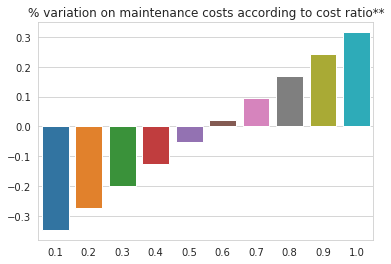

In [63]:
sns.barplot(x=ratio, y = delta_list)
plt.title('% variation on maintenance costs according to cost ratio**')
plt.show()

In [64]:
print('''Thus, if the cost ratio is 20% the overall economy would be \
{0:.0f}% and so forth'''.format(100*abs(delta_list[1])))

Thus, if the cost ratio is 20% the overall economy would be 27% and so forth
